[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgonzalezve/Diplomado_Ciencia_Datos/blob/master/Tareas/Tarea_6_GAMS.ipynb)

<img src = "Logounal.jpg" width="220">

[0/100, 0/938] D_loss: 1.328 G_loss: 0.695
[0/100, 100/938] D_loss: 1.200 G_loss: 1.079
[0/100, 200/938] D_loss: 1.375 G_loss: 0.810
[0/100, 300/938] D_loss: 1.458 G_loss: 0.673
[0/100, 400/938] D_loss: 1.252 G_loss: 0.966
[0/100, 500/938] D_loss: 1.184 G_loss: 0.993
[0/100, 600/938] D_loss: 1.383 G_loss: 0.834
[0/100, 700/938] D_loss: 1.148 G_loss: 1.062
[0/100, 800/938] D_loss: 1.076 G_loss: 1.125
[0/100, 900/938] D_loss: 0.981 G_loss: 1.451
Epoch 0 D_loss_avg: 1.250 G_loss_avg: 0.968
[1/100, 0/938] D_loss: 1.170 G_loss: 1.022
[1/100, 100/938] D_loss: 0.907 G_loss: 1.276
[1/100, 200/938] D_loss: 1.555 G_loss: 2.156
[1/100, 300/938] D_loss: 0.954 G_loss: 1.068
[1/100, 400/938] D_loss: 1.077 G_loss: 1.944
[1/100, 500/938] D_loss: 0.563 G_loss: 2.427
[1/100, 600/938] D_loss: 0.922 G_loss: 2.752
[1/100, 700/938] D_loss: 0.537 G_loss: 2.531
[1/100, 800/938] D_loss: 0.557 G_loss: 2.053
[1/100, 900/938] D_loss: 0.694 G_loss: 1.942
Epoch 1 D_loss_avg: 0.874 G_loss_avg: 1.820
[2/100, 0/938] D

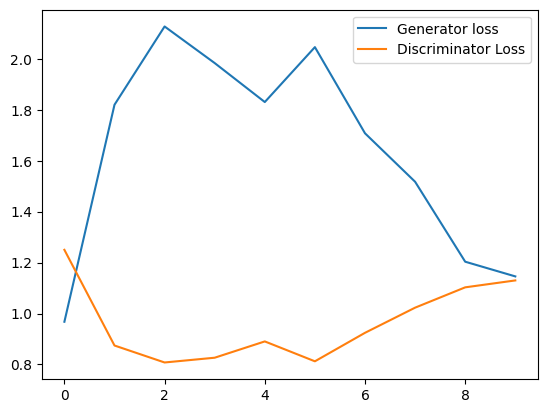

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

# device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.MNIST('/mnt/storage/Datasets', train=True, download=True, transform=transform)
#test_set = datasets.MNIST('/mnt/storage/Datasets', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return nn.Sigmoid()(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(64, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return nn.Tanh()(x)
    
generator = Generator().to(device)
discriminator = Discriminator().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss = nn.BCELoss()

def noise(size):
    n = torch.randn(size, 64)
    return n.to(device)

def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))  # Usar len(fake_data)
    error.backward()
    g_optimizer.step()
    return error

d_losses = []
g_losses = []

for epoch in range(10):
    N = len(train_loader)
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (images, _) in enumerate(train_loader):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(noise(len(real_data))).to(device)
        g_loss = generator_train_step(fake_data)
        d_loss_epoch += d_loss
        g_loss_epoch += g_loss
        if i % 100 == 0 or i == N:
            print('[{}/{}, {}/{}] D_loss: {:.3f} G_loss: {:.3f}'
                  .format(epoch, 100, i, len(train_loader), d_loss.item(), g_loss.item()))
    d_losses.append(d_loss_epoch/N)
    g_losses.append(g_loss_epoch/N)
    print('Epoch {} D_loss_avg: {:.3f} G_loss_avg: {:.3f}'
          .format(epoch, d_losses[-1], g_losses[-1]))
    
g_losses = [x.detach().cpu().numpy() for x in g_losses]
d_losses = [x.detach().cpu().numpy() for x in d_losses]
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure()
plt.plot(g_losses, label='Generator loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the transformation for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CelebA dataset
train_set = datasets.CelebA('/mnt/storage/Datasets', split='train', download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(512 * 4 * 4, 1)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return nn.Sigmoid()(x)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.activation


Files already downloaded and verified
